In [2]:
import cv2
# from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
from threading import Thread

from scipy.spatial import Delaunay
# from skimage.io import imread
import scipy.misc
from scipy.spatial import distance
import scipy

import dlib
import utils

In [3]:
# Data from: https://huggingface.co/datasets/wider_face
# unzip files into 'data' folder

data_dir            = 'data'

training_img_dir    = '/WIDER_train/images/'
test_img_dir        = '/WIDER_test/images/'
validation_img_dir  = '/WIDER_val/images/'

label_dir           = '/wider_face_split'
training_img_label  = '/wider_face_train_bbx_gt.txt'
val_img_label       = '/wider_face_val_bbx_gt.txt'

In [4]:
training_data = []

with open(data_dir + label_dir + training_img_label) as t:
    line = t.readline().strip('\n')
    num_img, max_img = 0, 50

    while line:
        if 'jpg' in line:
            num_img += 1
            if num_img > max_img:
                num_img -= 1
                break

            # If we need anything beyond bbx and img from data, 
            # uncomment the commented dictionary and data parsing bits below
            training_data.append({
                'img': cv2.cvtColor(cv2.imread(data_dir + training_img_dir + line, -1), cv2.COLOR_BGR2RGB),
                # 'img': Image.open(data_dir + training_img_dir + line),
                'bbx': [],
                # 'blur': [],
                # 'expression': [],
                # 'illumination': [],
                # 'occulsion': [],
                # 'pose': [],
                # 'invalid': []
            })

        else:
            if line.isnumeric(): # number of face bbx
                line = t.readline().strip('\n')
                continue
            else:
                face_data = line.split(' ')
                training_data[-1]['bbx'].append([int(coord) for coord in face_data[:4]])
                # training_data[-1]['blur'].append(int(face_data[4]))
                # training_data[-1]['expression'].append(int(face_data[5]))
                # training_data[-1]['illumination'].append(int(face_data[6]))
                # training_data[-1]['occulsion'].append(int(face_data[7]))
                # training_data[-1]['pose'].append(int(face_data[8]))
                # training_data[-1]['invalid'].append(not bool(face_data[9]))
        line = t.readline().strip('\n')

In [5]:
amongus_dir = data_dir + '/amongus'
among_us = [cv2.cvtColor(cv2.imread(f'{amongus_dir}/{file}', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGBA)[140:650, 175:650] # resize config
            for file in os.listdir(amongus_dir)]

# crop_config = (175, 140, 650, 650) # left, top, right bottom
# among_us = [Image.open(f'{amongus_dir}/{file}').crop(crop_config)
#             for file in os.listdir(amongus_dir)]

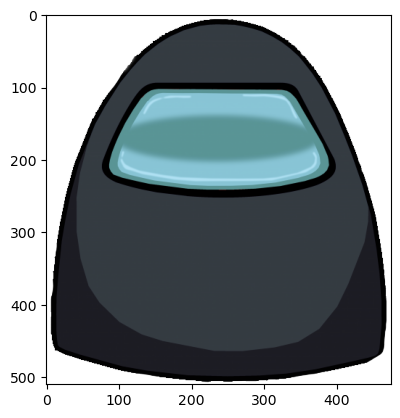

In [6]:
plt.imshow(among_us[0])
plt.show()

# Resize Amongus Face from BBX

0


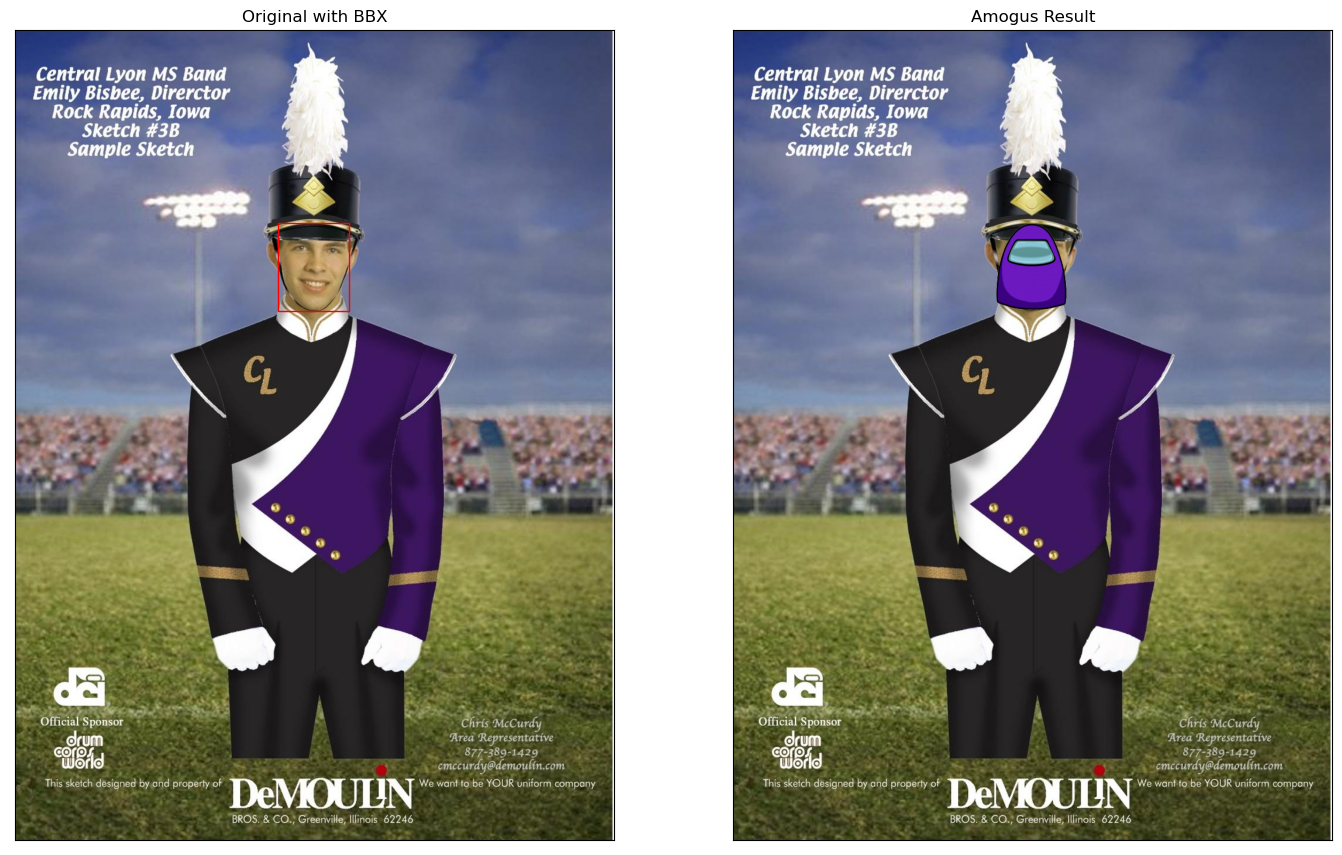

In [7]:
# i = np.random.randint(0, len(training_data))
i = 0
print(i)

train_img = training_data[i]['img']
res = train_img.copy()
threads = []

fig, axes = plt.subplots(1, 2, figsize=(17,20))
axes[0].imshow(train_img)
axes[0].set_title('Original with BBX'), axes[0].set_xticks([]), axes[0].set_yticks([])

def threading_amongus(bbx):
    a, b, width, height = bbx
    # resize a randomly chosen among-us face
    amongus = cv2.resize(among_us[np.random.randint(0, len(among_us))], (width, height), interpolation=cv2.INTER_AREA)

    # assign among-us face to the global result
    alpha = amongus[:, :, 3] / 255.0
    for channel in range(3):
        res[b:b+height, a:a+width, channel] = (1. - alpha) * train_img[b:b+height, a:a+width, channel] + alpha * amongus[:, :, channel]

    # add bounding box for the first image
    rect = patches.Rectangle((a, b), width, height, linewidth=1, edgecolor='r', facecolor='none')
    axes[0].add_patch(rect)

# parallellize the resizing & assigning of amongus faces
for bbx in training_data[i]['bbx']:
    threads.append(Thread(target=threading_amongus, args=(bbx,)))
    threads[-1].start()

# join all threads
for thread in threads:
    thread.join()

axes[1].imshow(res)
axes[1].set_title('Amogus Result'), axes[1].set_xticks([]), axes[1].set_yticks([])
plt.show()

# Detect Feature Points and Warp

In [8]:
a, b, width, height = bbx # image 1 only has 1 bbx
sub_img = train_img[b:b+height, a:a+width]
res_img = res[b:b+height, a:a+width]

def get_face_landmarks(img):
    detector = dlib.get_frontal_face_detector()
    # download predictor from http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    predictor = dlib.shape_predictor('data/shape_predictor_68_face_landmarks.dat') 

    dets = detector(img, 1)
    if len(dets) == 0:
        dets = dlib.rectangles()
        dets.append(dlib.rectangle(-32, 0, img.shape[0], img.shape[1]))
    
    pts = np.zeros((68, 2), np.int32)

    for d in dets:
        
        shape = predictor(img, d) # get landmark

        for i in range(68):
            pts[i, 0] = shape.part(i).x
            pts[i, 1] = shape.part(i).y
    
    return pts

In [9]:
original_lm = get_face_landmarks(sub_img)
amongus_lm = get_face_landmarks(res_img) # should only be computed once

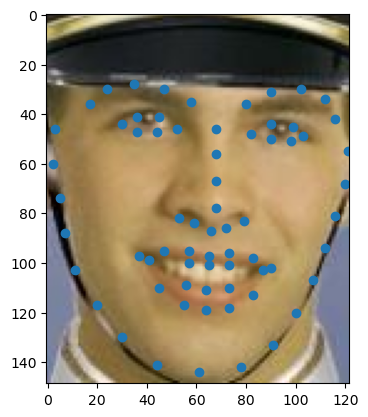

In [10]:
plt.imshow(sub_img)
plt.plot([x for x, _ in original_lm], [y for _, y in original_lm], 'o')
plt.show()

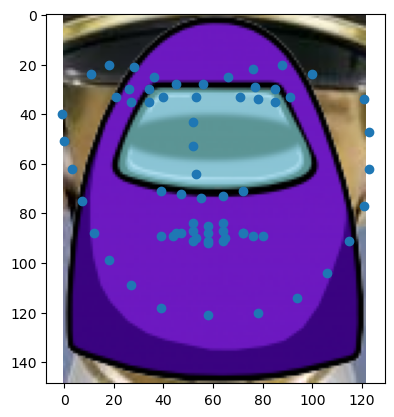

In [11]:
plt.imshow(res_img)
plt.plot([x for x, _ in amongus_lm], [y for _, y in amongus_lm], 'o')
plt.show()

As can be seen above, the automatic feature finding algorithm doesn't work for the Among Us face. We manually mapped the feature points to fix this.

# Feature points for Among Us Face

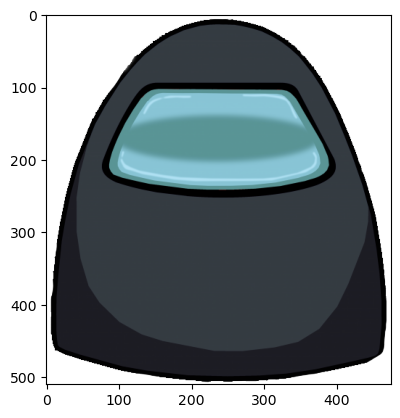

In [12]:
plt.imshow(among_us[0])

In [13]:
# Manually assigned text file of among us feature points
with open('data/amongus_points.txt') as f:
    feature_points = f.readlines()

amongus_feature_points = []
for index, point in enumerate(feature_points):
    coord = point.strip()
    x,y = coord.split(',')
    x = int(x)
    y = int(y)
    amongus_feature_points.append((x,y))
amongus_feature_points = np.array(amongus_feature_points)
amongus_feature_points -= (175,143) # For some reason the tool I used had an offset

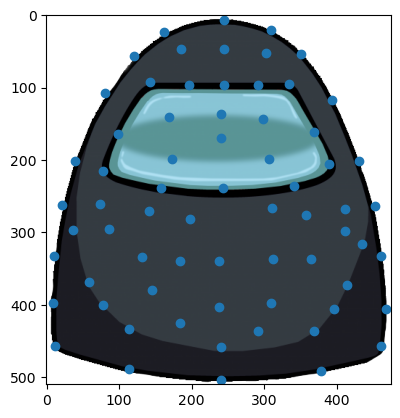

In [14]:
# Manually mapped feature points
plt.imshow(among_us[0])
amongus_x_feature = amongus_feature_points[:,0]
amongus_y_feature = amongus_feature_points[:,1]
plt.plot(amongus_x_feature, amongus_y_feature, 'o')
plt.show()

In [15]:
# Feature points can be remapped by using a ratio of new_dim/old_dim
def resize_amongus_features(x_feature, y_feature, new_width, new_height, image):
    height, width, _ = image.shape
    resized_feature_x = amongus_x_feature * (new_width/width)
    resized_feature_y = amongus_y_feature * (new_height/height)
    return resized_feature_x.astype(int), resized_feature_y.astype(int)

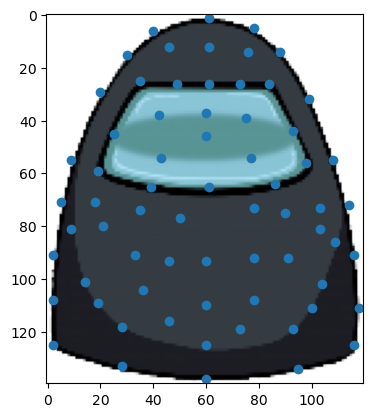

In [16]:
new_width = 120
new_height = 140
resized_amongus = cv2.resize(among_us[0], (new_width, new_height))
plt.imshow(resized_amongus)
resized_feature_x,resized_feature_y = resize_amongus_features(amongus_x_feature, amongus_y_feature, new_width, new_height, among_us[0])
plt.plot(resized_feature_x, resized_feature_y, 'o')
plt.show()

# Resized Among Us face with feature points

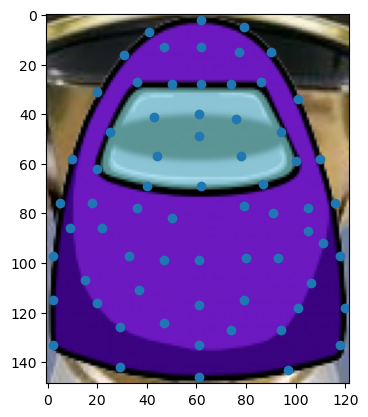

In [17]:
new_height, new_width, _ = res_img.shape
resized_feature_x, resized_feature_y = resize_amongus_features(amongus_x_feature, amongus_y_feature, new_width, new_height, among_us[0])
plt.imshow(res_img)
plt.plot(resized_feature_x, resized_feature_y, 'o')
plt.show()

In [18]:
# Get arrays of feature points
among_us_point = np.vstack((resized_feature_x, resized_feature_y)).T # Combine x and y feature coords into one array
orig_point = np.array(original_lm)
# Get index of which Among Us points are closest to the original feature points
# closest = np.zeros(orig_point.shape, dtype=int)
# dist = distance.cdist(orig_point, among_us_point)
# min_index = np.argmin(dist, axis=1) # Indices of Among Us feature points nearest to the original image feature point

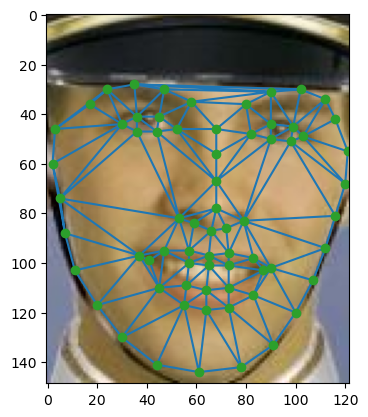

In [19]:
plt.imshow(sub_img)
tri_orig = Delaunay(orig_point)
plt.triplot(orig_point[:,0], orig_point[:,1], tri_orig.simplices)
plt.plot(orig_point[:,0], orig_point[:,1], 'o')

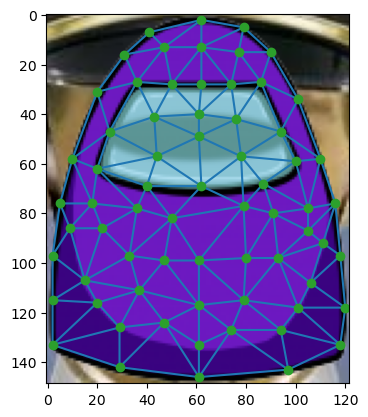

In [20]:
plt.imshow(res_img)
tri_among_us = Delaunay(among_us_point)
plt.triplot(among_us_point[:,0], among_us_point[:,1], tri_among_us.simplices)
plt.plot(among_us_point[:,0], among_us_point[:,1], 'o')

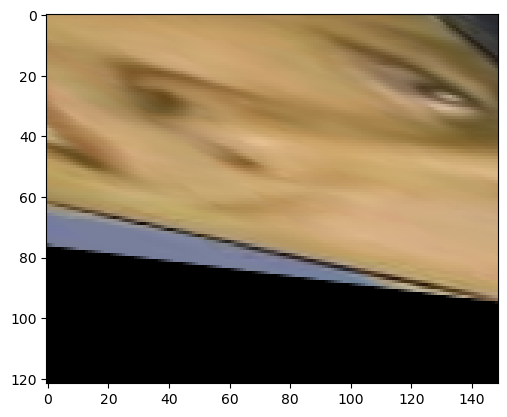

In [94]:
tri_orig_points = tri_orig.simplices.copy()
tri_among_points = tri_among_us.simplices[:-1].copy()
# print(tri_orig_points, tri_among_points)
# print(tri_orig_points)
# test0 = among_us_point[tri_among_points[0]].astype(np.float32)
# print(test0)
# test1 = orig_point[tri_orig_points[0]].astype(np.float32)
# print(test1)
# width = sub_img.shape[0]
# height = sub_img.shape[1]
# new_image = np.zeros((width, height))

for index, (among_tri, orig_tri) in enumerate(zip(tri_among_points, tri_orig_points)):
    among_warp_point = among_us_point[among_tri].astype(np.float32)
    orig_warp_point = orig_point[orig_tri].astype(np.float32)
#     print(orig_warp_point)
    warp_mat = cv2.getAffineTransform(orig_warp_point, among_warp_point)
    
# warp_mat = cv2.getAffineTransform(test1, test0)
warp_img_1 = cv2.warpAffine(sub_img, warp_mat, (sub_img.shape[0], sub_img.shape[1]))
plt.imshow(warp_img_1)

In [37]:
def hybridImage(im1, im2, cutoff_low, cutoff_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        cutoff_low: standard deviation for the low-pass filter
        cutoff_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''    
    # Create 2D gaussian kernel for lpf
    fil = utils.gaussian_kernel(cutoff_low, cutoff_low)
    lpf_im = cv2.filter2D(im1, -1, fil)
    
    # Create 2D gaussian kernel for hpf
    fil = utils.gaussian_kernel(cutoff_high, cutoff_high)
    hpf_im = im2 - cv2.filter2D(im2, -1, fil)
    
    return lpf_im + hpf_im

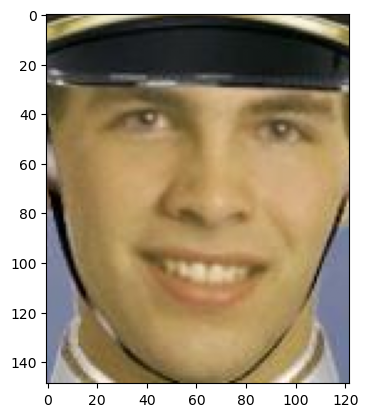

In [23]:
cutoff_low = 2
cutoff_high = 20
# im1 = cv2.cvtColor(res_img, cv2.COLOR_RGB2GRAY) / 255.0
# im2 = cv2.cvtColor(sub_img, cv2.COLOR_RGB2GRAY) / 255.0

orig_face_float = sub_img / 255.0
height = orig_face_float.shape[0]
width = orig_face_float.shape[1]
among_face_float = cv2.resize(among_us[0][:,:,:3], (width, height)) / 255.0
im_hybrid = hybridImage(among_face_float, orig_face_float, cutoff_low, cutoff_high)
plt.imshow(orig_face_float)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50 30


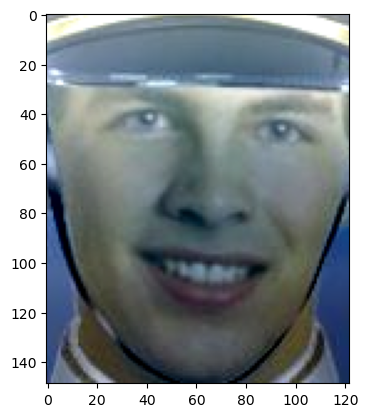

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47 28


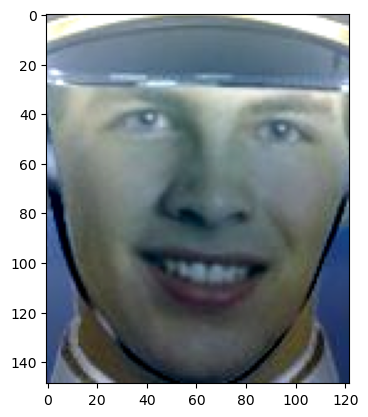

44 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


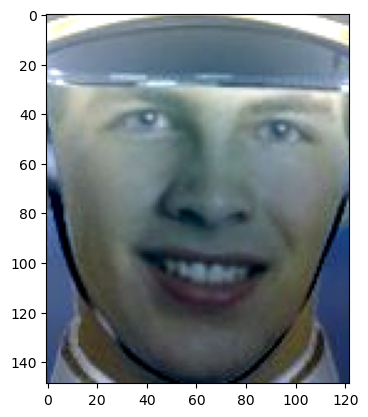

42 25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


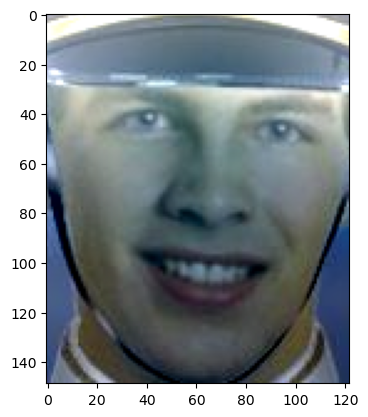

39 23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


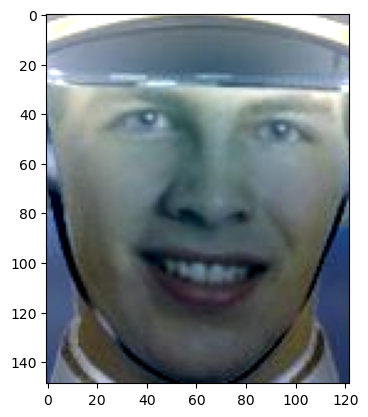

36 22


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


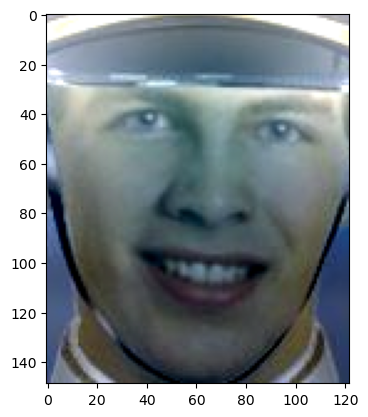

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


34 20


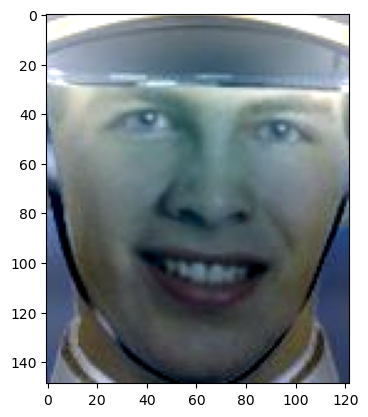

31 18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


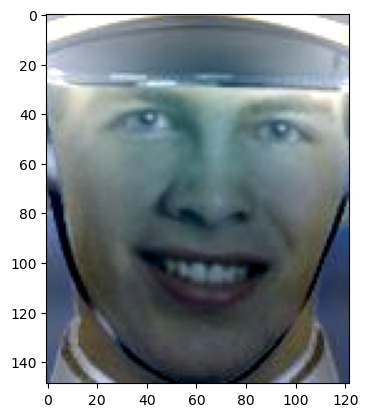

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28 17


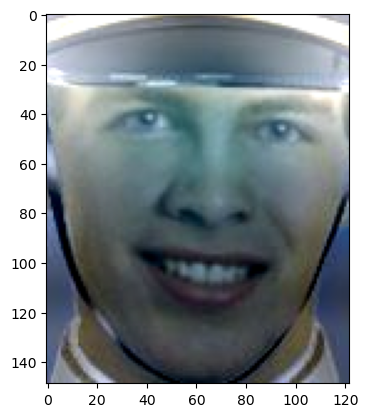

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


26 15


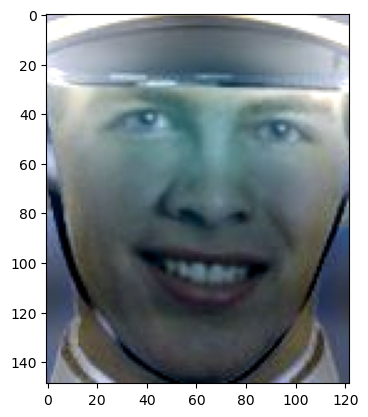

23 14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


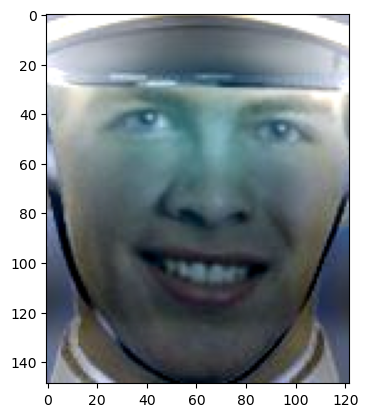

21 12


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


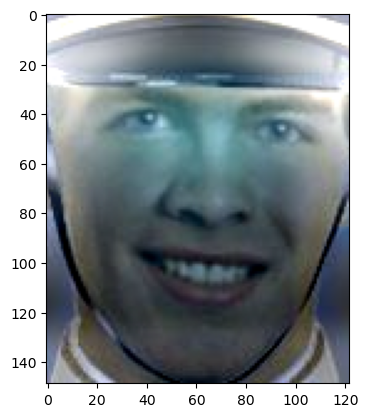

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18 11


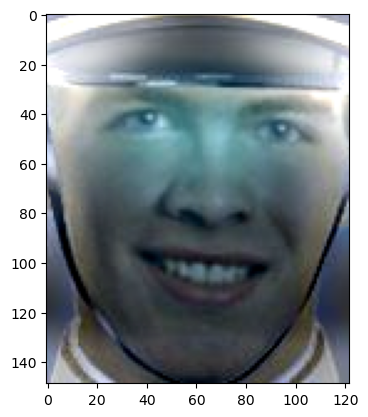

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


15 9


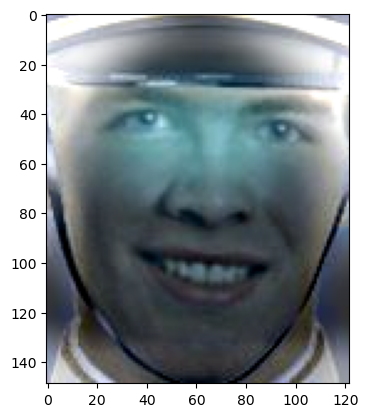

13 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


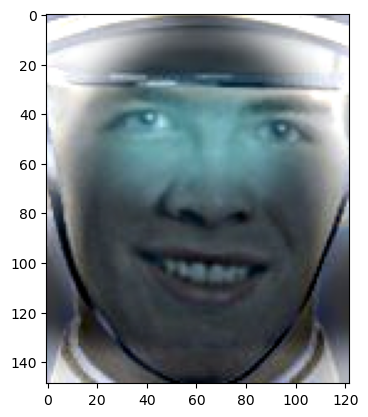

10 6


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


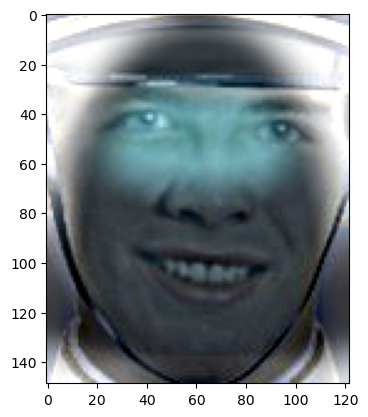

7 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


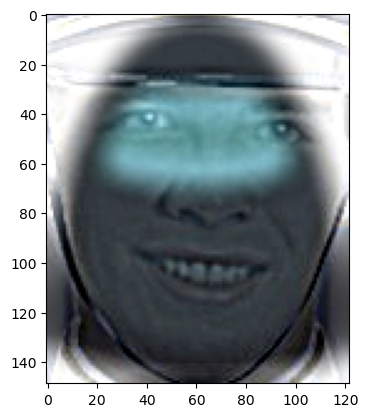

5 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


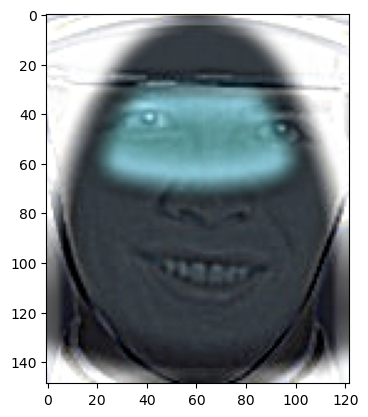

2 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


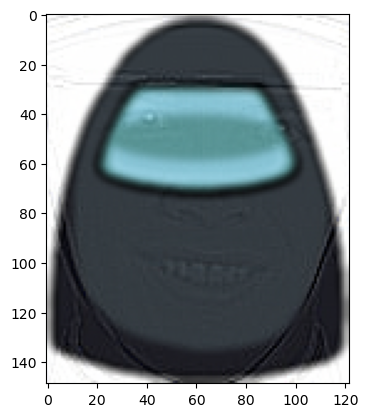

0 0


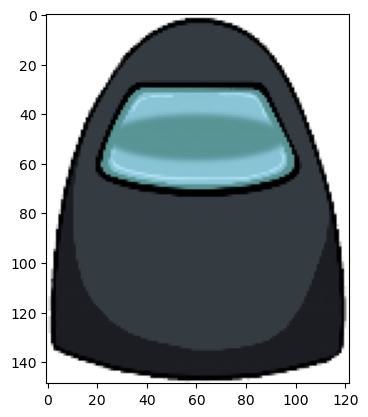

In [99]:
# cutoff_low = 0
# cutoff_high = 0
# cutoff_low = range(0, 110, 10)
# cutoff_low = range(110, -10, -10)
# cutoff_high = range(30, -3, -3)
cutoff_low = np.linspace(25, 0, 20).astype(int)
cutoff_high = np.linspace(30, 0, 20).astype(int)
# for i in range(20):
#     im_hybrid = hybridImage(among_face_float, orig_face_float, cutoff_low, cutoff_high)
#     plt.figure()
#     plt.imshow(im_hybrid)
#     plt.show()
#     im_hybrid = hybridImage(orig_face_float, among_face_float, cutoff_low, cutoff_high)
#     plt.figure()
#     plt.imshow(im_hybrid)
#     plt.show()
for low, high in zip(cutoff_low, cutoff_high):
    print(low, high)
    im_hybrid = hybridImage(among_face_float, orig_face_float, low, high)
    plt.figure()
    plt.imshow(im_hybrid)
    plt.show()
#     im_hybrid = hybridImage(orig_face_float, among_face_float, low, high)
#     plt.figure()
#     plt.imshow(im_hybrid)
#     plt.show()